<a href="https://colab.research.google.com/github/electropavuk/crypto_trader/blob/master/ipynb/MACD_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# !pip install python-dotenv python-binance 

In [4]:
import os
import datetime
import random
from itertools import product

from dotenv import load_dotenv
from binance import Client
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

np.set_printoptions(edgeitems=10, linewidth=200)
pd.options.mode.chained_assignment = None 

google_drive_dir = '/content/drive/MyDrive/Colab Notebooks/crypto_trader/'
load_dotenv(google_drive_dir + '.env')

api_key = os.getenv('READONLY_API_KEY')
secret_key = os.getenv('READONLY_SECRET_KEY')

client = Client(api_key, secret_key)

In [5]:
def get_history(symbol, interval, period):
    base, quote = 'BTC', 'USDT'
    klines = client.get_historical_klines(symbol=symbol, interval=interval, start_str= period + ' ago UTC')
    labels = ['Open time', 'Open', 'High', 'Low', 'Close', 
    		  base + ' volume', 'Close time', quote + ' volume', 'Number of trades',
    		  f'{base} buy volume', f'{quote} sell volume', 'Ignore']
    df = pd.DataFrame(data=klines, columns=labels, dtype=float)
    return df


history = get_history(symbol='BTCUSDT', interval='1h', period='4 years')

In [6]:
def prepare_data(df, fast=12, slow=26, avg=9):
    df = df[['Close']]

    df[f'MACD'] = df['Close'].ewm(span=fast).mean() - df['Close'].ewm(span=slow).mean()
    df[f'signal line'] = df['MACD'].ewm(span=avg).mean()
    df[f'histogram'] = df['MACD'] - df['signal line']
    
    df = df.dropna()
    
    return df


In [7]:
def simulate(model, data, n, fast=12, slow=26, avg=9, money=100, commision=0.00075):

    trades = []
    init_money = balance = money
    clean = 1 - commision
    quantity = 0

    for t in range(-n, -1):
        action = model(data, t)
        price = data['Close'].iloc[t]
        if action == 'buy' and balance > 0:
            buy_price = price
            quantity = clean * balance / price
            balance = 0
            trades.append(('buy', t, price, balance))
        elif action == 'sell' and quantity > 0:
            balance = clean * quantity * price
            trades.append(('sell', t, price, balance))
            quantity = 0
    
    if quantity > 0:
        balance += quantity * buy_price
        trades.pop()
    
    profit = (balance - init_money) / init_money
    return trades, profit

In [16]:
def config_plot(plt):
    plt.figure(figsize = (30, 5))
    plt.xlim((-n, 0))
    plt.grid(True)

def show_graph(data, trades):
    config_plot(plt)
    xsell, ysell, xbuy, ybuy = [], [], [], []
    for action, t, price, _ in trades:
        if action == 'buy':
            xbuy.append(t)
            ybuy.append(price)
        if action == 'sell':
            xsell.append(t)
            ysell.append(price)

    plt.title('{} trades made, profit {:.1f} %'.format(len(trades), profit * 100))
    plt.plot(range(-n, 0), data['Close'].iloc[-n:], label='Closing price', c='black')
    plt.scatter(xbuy, ybuy, label='Buy', c='blue')
    plt.scatter(xsell, ysell, label='Sell', c='red')
    plt.legend()



def show_macd(data):
    config_plot(plt)
    plt.title('MACD')
    plt.plot(range(-n, 0), data['MACD'].iloc[-n:], label='MACD', c='blue')
    plt.plot(range(-n, 0), data['signal line'].iloc[-n:], label='signal line', c='red')
    plt.plot(range(-n, 0), data['histogram'].iloc[-n:], label='histogram', c='gray', linestyle=':')
    plt.legend()



def show_profit(data, trades):
    config_plot(plt)
    xprofit, yprofit = [], []
    balance = init_money = money
    for action, t, price, balance in trades:
        if balance > 0:
            xprofit.append(t)
            yprofit.append(100 * (balance - init_money) / init_money)
        

    plt.title('params {} : profit = {:.1f} %'.format((fast, slow, avg), profit * 100))
    plt.plot(xprofit, yprofit, label='Profit', c='black', linestyle=':')
    plt.legend()

In [9]:
class SignalLineCrossover:
    def __init__(self, patience=1):
        self.patience = patience

    def __call__(self, data, t):
        signal_line = data['signal line'].iloc[t - self.patience: t + 1].to_numpy()
        macd = data['MACD'].iloc[t - self.patience: t + 1].to_numpy()
        diff = macd > signal_line
        if not diff[0] and all(diff[1:]):
            return 'buy'
        elif diff[0] and not any(diff[1:]):
            return 'sell'
        else:
            return 'wait'

In [10]:
def search_parameters(model, search_space):
    params = product(search_space, repeat=3)
    params = [(fast, slow, avg) for fast, slow, avg in params if fast < slow]

    profits = []
    for fast, slow, avg in params:
        data = prepare_data(history, fast, slow, avg)
        trades, profit = simulate(model, data, n, fast, slow, avg, money)
        # print('params {} : profit = {:.1f} %'.format((fast, slow, avg), profit * 100))
        profits.append((profit, (fast, slow, avg)))

    profit, (fast, slow, avg) = max(profits)
    print('BEST')
    print('params {} : profit = {:.1f} %'.format((fast, slow, avg), profit * 100))
    return fast, slow, avg

BEST
params (7, 11, 7) : profit = 41.7 %


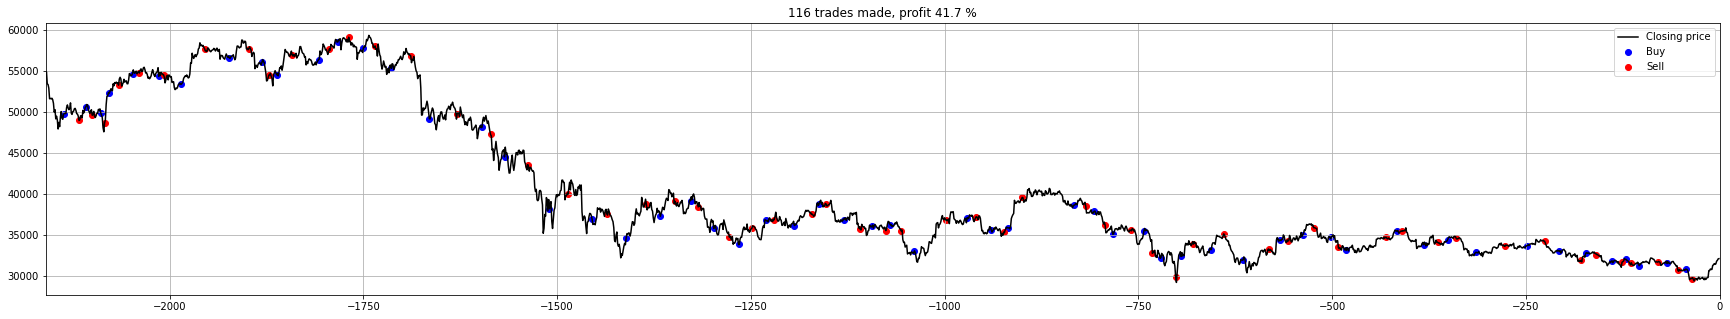

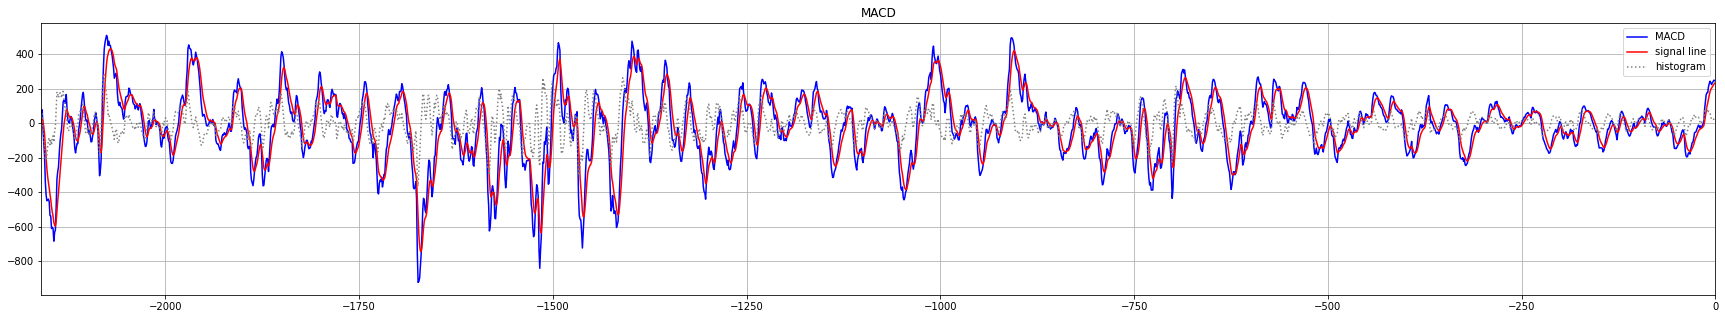

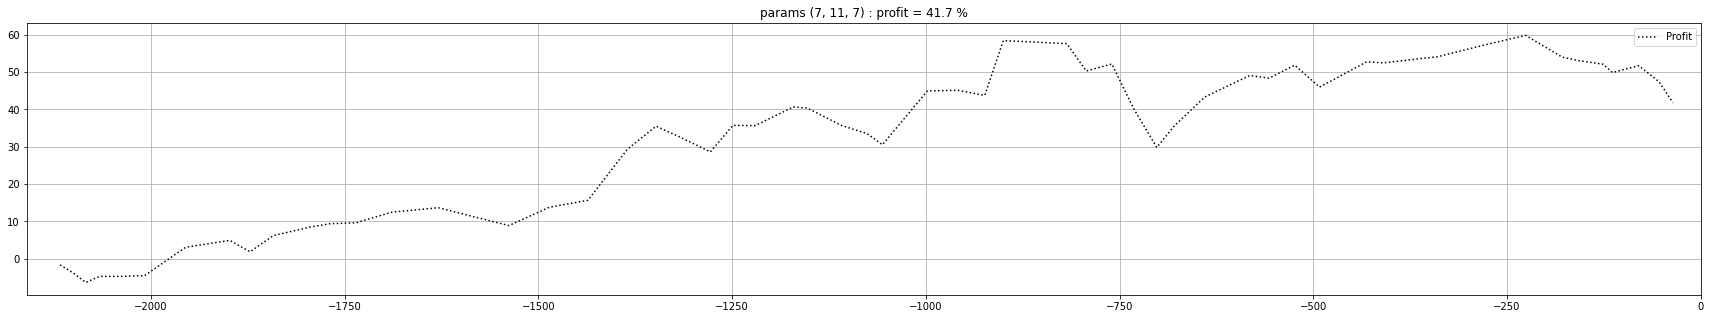

In [19]:
money = 100
n = 24 * 90
model = SignalLineCrossover(patience=5)

# fast, slow, avg = 8, 11, 7
fast, slow, avg = search_parameters(model, search_space=range(7, 13))

data = prepare_data(history, fast, slow, avg)


trades, profit = simulate(model, data, n, fast=12, slow=26, avg=9, money=money, commision=0.00075)



show_graph(data, trades)
show_macd(data)
show_profit(data, trades)